# 🧠 Neural Network Tutorial: From Neuron to MLP

**"우리는 뇌를 모방한 인공 신경망을 처음부터 만들어봅니다"**

이 노트북에서는:
1. 🔸 **Neuron**: 가장 작은 학습 단위
2. 🔲 **Layer**: 뉴런들의 집합
3. 🏗️ **MLP**: 다층 신경망
4. 🎯 **XOR**: 신경망의 Hello World

---

## 📚 Part 0: 준비

먼저 필요한 모듈을 import합니다.

In [1]:
import sys
import os
import random
import math
import numpy as np
import matplotlib.pyplot as plt

# 프로젝트 경로 추가
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('.'))))

# Tiny Autograd import
from tiny_autograd_project._10_core.autograd_tiny.value import Value

# 시드 고정
random.seed(42)
np.random.seed(42)

print("✅ 준비 완료!")

✅ 준비 완료!


## 🔸 Part 1: Neuron - 가장 작은 단위

### 생물학적 뉴런 vs 인공 뉴런

생물학적 뉴런:
- 수상돌기(Dendrites): 입력 받기
- 세포체(Cell Body): 신호 처리
- 축삭(Axon): 출력 전달

인공 뉴런:
- 입력: x₁, x₂, ..., xₙ
- 가중치: w₁, w₂, ..., wₙ
- 편향: b
- 활성화: f(Σwᵢxᵢ + b)

In [20]:
class SimpleNeuron:
    """간단한 뉴런 구현 (교육용)"""
    
    def __init__(self, nin):
        """nin개의 입력을 받는 뉴런 생성"""
        # 가중치 초기화 (-1 ~ 1 사이 랜덤)
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        # 편향 초기화 (0으로 시작)
        self.b = Value(0)
    
    def __call__(self, x):
        """Forward pass: 입력을 받아 출력 생성"""
        # 가중합 계산: Σ(wi * xi) + b
        activation = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        # 활성화 함수 (tanh) 적용
        output = activation.tanh()
        return output
    
    def parameters(self):
        """학습 가능한 파라미터 반환"""
        return self.w + [self.b]

# 테스트
neuron = SimpleNeuron(2)
x = [Value(0.5), Value(-0.5)]
y = neuron(x)

print(f"입력: {[xi.data for xi in x]}")
print(f"출력: {y.data:.4f}")
print(f"파라미터: {neuron.parameters()}")
print(f"파라미터 개수: {len(neuron.parameters())}")

입력: [0.5, -0.5]
출력: 0.5664
파라미터: [Value(data=0.412838, grad=0.000000), Value(data=-0.871542, grad=0.000000), Value(data=0.000000, grad=0.000000)]
파라미터 개수: 3


/opt/homebrew/anaconda3/envs/ai/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54632 (\N{HANGUL SYLLABLE HAM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/envs/ai/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/envs/ai/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/envs/ai/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/envs/ai/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51216 (\N{H

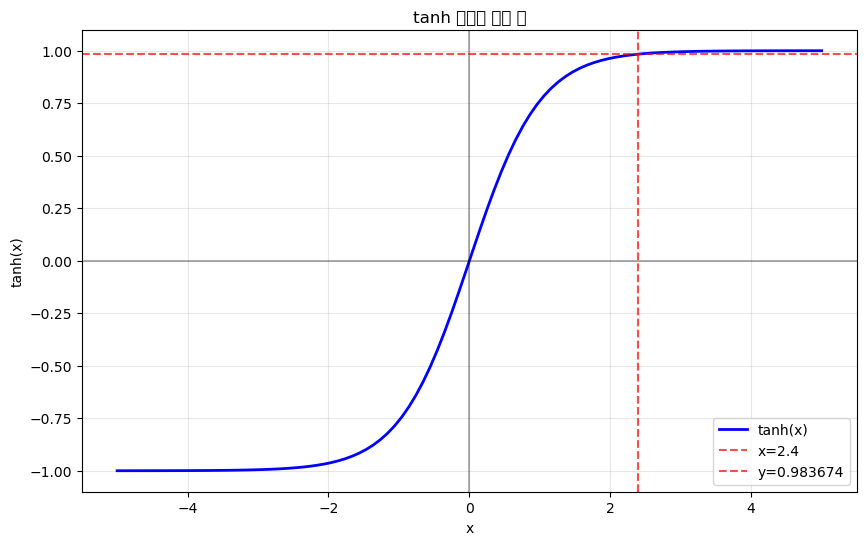

In [10]:
import matplotlib.pyplot as plt
import numpy as np

x_range = np.linspace(-5, 5, 100)
y_tanh = np.tanh(x_range)

plt.figure(figsize=(10, 6))
plt.plot(x_range, y_tanh, 'b-', linewidth=2, label='tanh(x)')
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=2.4, color='r', linestyle='--', alpha=0.7, label='x=2.4')
plt.axhline(y=0.983674, color='r', linestyle='--', alpha=0.7, label='y=0.983674')
plt.grid(True, alpha=0.3)
plt.xlabel('x')
plt.ylabel('tanh(x)')
plt.title('tanh 함수와 예시 점')
plt.legend()
plt.show()

### 🔍 뉴런의 학습 과정 시각화

/var/folders/2d/g5tj3tv95294zzy7wpnxf8wc0000gn/T/ipykernel_24969/3726932555.py:66: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/2d/g5tj3tv95294zzy7wpnxf8wc0000gn/T/ipykernel_24969/3726932555.py:66: UserWarning: Glyph 49845 (\N{HANGUL SYLLABLE SEUB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/2d/g5tj3tv95294zzy7wpnxf8wc0000gn/T/ipykernel_24969/3726932555.py:66: UserWarning: Glyph 44257 (\N{HANGUL SYLLABLE GOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/2d/g5tj3tv95294zzy7wpnxf8wc0000gn/T/ipykernel_24969/3726932555.py:66: UserWarning: Glyph 49440 (\N{HANGUL SYLLABLE SEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/2d/g5tj3tv95294zzy7wpnxf8wc0000gn/T/ipykernel_24969/3726932555.py:66: UserWarning: Glyph 44172 (\N{HANGUL SYLLABLE GE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/2d/g5tj3tv95294zzy7wpnxf8wc0000gn/T/ipyke

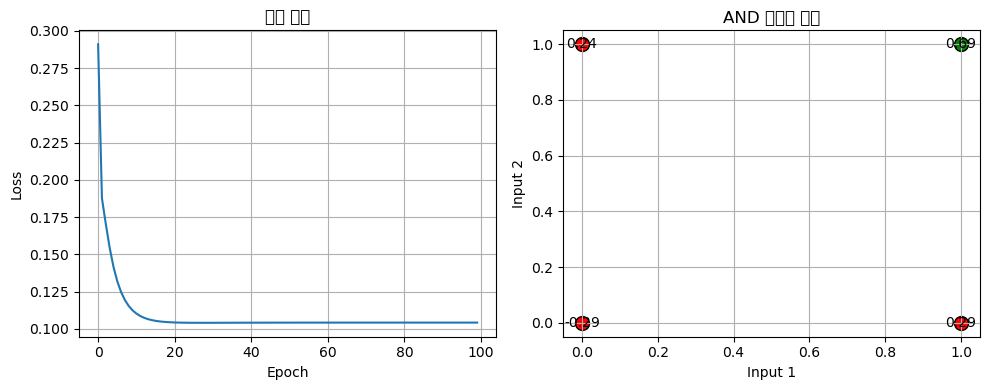

In [21]:
# 간단한 학습 예제: 뉴런이 AND 게이트 학습
def train_single_neuron():
    # AND 게이트 데이터
    X = [[0, 0], [0, 1], [1, 0], [1, 1]]
    y = [0, 0, 0, 1]  # AND 출력
    
    # 뉴런 생성
    neuron = SimpleNeuron(2)
    
    # 학습 기록
    losses = []
    
    # 학습
    for epoch in range(100):
        total_loss = 0
        
        for inputs, target in zip(X, y):
            # print(f"학습 {epoch} >> {inputs}, {target}")
            
            x_vals = [Value(x) for x in inputs]
            # print(f"학습 {epoch} >> {x_vals}")
            pred = neuron(x_vals)
            # print(f"학습 {epoch} pred >> {pred}")
            
            # Loss
            loss = (pred - Value(target)) ** 2
            # print(f"학습 {epoch} loss >> {loss}")
            total_loss += loss.data
            
            # Backward
            for p in neuron.parameters():
                p.grad = 0
            loss.backward()
            
            # Update (SGD)
            for p in neuron.parameters():
                p.data -= 0.1 * p.grad
        
        losses.append(total_loss / 4)
    
    # 결과 시각화
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.title('학습 곡선')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    # 최종 예측
    for inputs, target in zip(X, y):
        x_vals = [Value(x) for x in inputs]
        pred = neuron(x_vals)
        plt.scatter(inputs[0], inputs[1], 
                   c='green' if pred.data > 0.5 else 'red',
                   s=100, edgecolor='black')
        plt.text(inputs[0], inputs[1], f'{pred.data:.2f}', 
                ha='center', va='center')
    
    plt.title('AND 게이트 예측')
    plt.xlabel('Input 1')
    plt.ylabel('Input 2')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return neuron

# 실행
trained_neuron = train_single_neuron()

## 🔲 Part 2: Layer - 뉴런들의 집합

Layer는 여러 뉴런을 포함합니다.
각 뉴런은 같은 입력을 받지만, 다른 가중치를 가집니다.

In [31]:
class SimpleLayer:
    """뉴런들의 집합"""
    
    def __init__(self, nin, nout):
        """nin 입력을 받아 nout 출력을 생성하는 층"""
        self.neurons = [SimpleNeuron(nin) for _ in range(nout)]
        # print(f"SimpleLayer created with ({nin}, {nout})")
        # print(f"SimpleLayer parameters: {self.parameters()}")
    
    def __call__(self, x):
        """모든 뉴런에 입력 전달"""
        outputs = [neuron(x) for neuron in self.neurons]
        return outputs[0] if len(outputs) == 1 else outputs
    
    def parameters(self):
        """모든 뉴런의 파라미터"""
        return [p for neuron in self.neurons for p in neuron.parameters()]

# 테스트
layer = SimpleLayer(3, 2)  # 3입력 → 2출력
x = [Value(1), Value(2), Value(3)]
y = layer(x)

print(f"입력 차원: 3")
print(f"출력 차원: 2")
print(f"출력값: {[yi.data for yi in y]}")
print(f"총 파라미터: {layer.parameters()}")
print(f"총 파라미터 개수: {len(layer.parameters())}개")

입력 차원: 3
출력 차원: 2
출력값: [-0.996554493844224, -0.8254222937322637]
총 파라미터: [Value(data=0.899223, grad=0.000000), Value(data=-0.601279, grad=0.000000), Value(data=-0.959240, grad=0.000000), Value(data=0.000000, grad=0.000000), Value(data=-0.695235, grad=0.000000), Value(data=-0.747558, grad=0.000000), Value(data=0.338918, grad=0.000000), Value(data=0.000000, grad=0.000000)]
총 파라미터 개수: 8개


## 🏗️ Part 3: MLP - Multi-Layer Perceptron

여러 층을 연결하여 깊은 신경망을 만듭니다.

In [34]:
class SimpleMLP:
    """다층 퍼셉트론"""
    
    def __init__(self, nin, nouts):
        """nin 입력, nouts=[n1, n2, ...] 각 층의 뉴런 수"""
        sz = [nin] + nouts
        self.layers = []
        
        for i in range(len(nouts)):
            self.layers.append(SimpleLayer(sz[i], sz[i+1]))
    
    def __call__(self, x):
        """순차적으로 모든 층 통과"""
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        """모든 층의 파라미터"""
        return [p for layer in self.layers for p in layer.parameters()]

# 테스트: 2-4-4-1 구조
mlp = SimpleMLP(2, [4, 4, 1])
x = [Value(0.5), Value(0.5)]
y = mlp(x)

print(f"네트워크 구조: 2 → 4 → 4 → 1")
print(f"입력: {[xi.data for xi in x]}")
print(f"출력: {y.data}")
print(f"총 파라미터: {len(mlp.parameters())}개")

네트워크 구조: 2 → 4 → 4 → 1
입력: [0.5, 0.5]
출력: -0.08642031255659485
총 파라미터: 37개


## 🎯 Part 4: XOR Problem - 신경망의 Hello World

XOR은 선형으로 분리할 수 없는 문제입니다.
은닉층이 있는 신경망이 필요합니다!

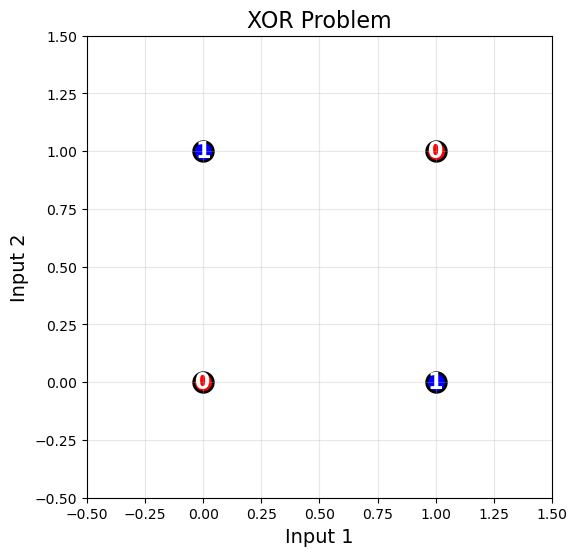

빨강(0)과 파랑(1)을 선 하나로 분리할 수 있나요?
→ 불가능! 은닉층이 필요합니다.


In [6]:
# XOR 데이터
X_xor = [[0, 0], [0, 1], [1, 0], [1, 1]]
y_xor = [0, 1, 1, 0]

# 시각화
plt.figure(figsize=(6, 6))
for inputs, target in zip(X_xor, y_xor):
    color = 'blue' if target == 1 else 'red'
    plt.scatter(inputs[0], inputs[1], c=color, s=200, edgecolor='black', linewidth=2)
    plt.text(inputs[0], inputs[1], f'{target}', 
            ha='center', va='center', fontsize=16, color='white', fontweight='bold')

plt.title('XOR Problem', fontsize=16)
plt.xlabel('Input 1', fontsize=14)
plt.ylabel('Input 2', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1.5)
plt.show()

print("빨강(0)과 파랑(1)을 선 하나로 분리할 수 있나요?")
print("→ 불가능! 은닉층이 필요합니다.")

### 🚀 XOR 학습하기

In [7]:
def train_xor_network(epochs=1000, lr=0.5, hidden_size=4):
    """XOR 문제를 해결하는 신경망 학습"""
    
    # 모델 생성
    model = SimpleMLP(2, [hidden_size, 1])
    print(f"🏗️ 모델 구조: 2 → {hidden_size} → 1")
    print(f"📊 총 파라미터: {len(model.parameters())}개\n")
    
    # 학습 기록
    history = []
    
    # 학습 루프
    for epoch in range(epochs):
        total_loss = 0
        
        for inputs, target in zip(X_xor, y_xor):
            # Forward pass
            x_vals = [Value(x) for x in inputs]
            pred = model(x_vals)
            
            # Loss 계산
            loss = (pred - Value(target)) ** 2
            total_loss += loss.data
            
            # Backward pass
            for p in model.parameters():
                p.grad = 0
            loss.backward()
            
            # Parameter update (SGD)
            for p in model.parameters():
                p.data -= lr * p.grad
        
        avg_loss = total_loss / len(X_xor)
        history.append(avg_loss)
        
        # 진행 상황 출력
        if epoch % 100 == 0:
            print(f"Epoch {epoch:4d}: Loss = {avg_loss:.6f}")
    
    return model, history

# 학습 실행
print("🎯 XOR 학습 시작...\n")
xor_model, loss_history = train_xor_network(epochs=1000, lr=0.5, hidden_size=4)
print("\n✅ 학습 완료!")

🎯 XOR 학습 시작...

🏗️ 모델 구조: 2 → 4 → 1
📊 총 파라미터: 17개

Epoch    0: Loss = 0.418324
Epoch  100: Loss = 0.167075
Epoch  200: Loss = 0.125342
Epoch  300: Loss = 0.067071
Epoch  400: Loss = 0.045326
Epoch  500: Loss = 0.054418
Epoch  600: Loss = 0.125219
Epoch  700: Loss = 0.064892
Epoch  800: Loss = 0.102694
Epoch  900: Loss = 0.086752

✅ 학습 완료!


### 📊 학습 결과 분석

/var/folders/2d/g5tj3tv95294zzy7wpnxf8wc0000gn/T/ipykernel_24969/2178531381.py:57: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/2d/g5tj3tv95294zzy7wpnxf8wc0000gn/T/ipykernel_24969/2178531381.py:57: UserWarning: Glyph 49845 (\N{HANGUL SYLLABLE SEUB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/2d/g5tj3tv95294zzy7wpnxf8wc0000gn/T/ipykernel_24969/2178531381.py:57: UserWarning: Glyph 44257 (\N{HANGUL SYLLABLE GOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/2d/g5tj3tv95294zzy7wpnxf8wc0000gn/T/ipykernel_24969/2178531381.py:57: UserWarning: Glyph 49440 (\N{HANGUL SYLLABLE SEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/2d/g5tj3tv95294zzy7wpnxf8wc0000gn/T/ipykernel_24969/2178531381.py:57: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/2d/g5tj3tv95294zzy7wpnxf8wc0000gn/T/ipyke

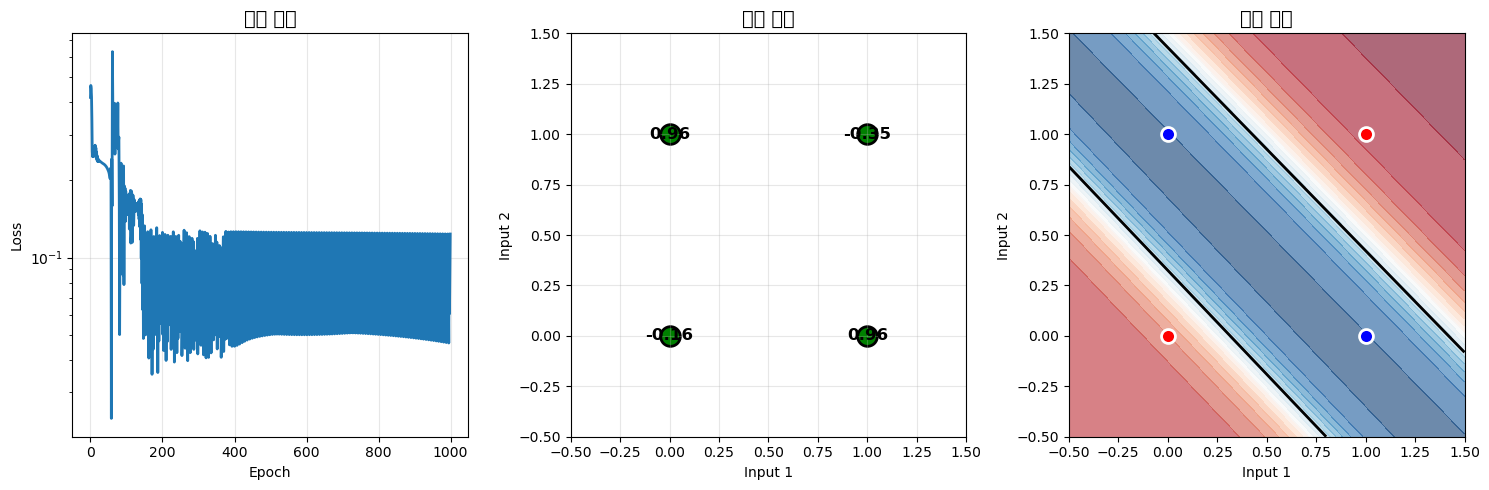


📊 최종 결과:
[0, 0] → 예측: -0.1647 (클래스: 0), 정답: 0 ✓
[0, 1] → 예측: 0.9631 (클래스: 1), 정답: 1 ✓
[1, 0] → 예측: 0.9628 (클래스: 1), 정답: 1 ✓
[1, 1] → 예측: -0.3484 (클래스: 0), 정답: 0 ✓
🎯 정확도: 100.0%


In [8]:
# 결과 시각화
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. 학습 곡선
axes[0].plot(loss_history, linewidth=2)
axes[0].set_title('학습 곡선', fontsize=14)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True, alpha=0.3)
axes[0].set_yscale('log')

# 2. 최종 예측
predictions = []
for inputs in X_xor:
    x_vals = [Value(x) for x in inputs]
    pred = xor_model(x_vals)
    predictions.append(pred.data)

for i, (inputs, target, pred) in enumerate(zip(X_xor, y_xor, predictions)):
    color = 'green' if abs(pred - target) < 0.5 else 'red'
    axes[1].scatter(inputs[0], inputs[1], c=color, s=200, edgecolor='black', linewidth=2)
    axes[1].text(inputs[0], inputs[1], f'{pred:.2f}', 
                ha='center', va='center', fontsize=12, fontweight='bold')

axes[1].set_title('모델 예측', fontsize=14)
axes[1].set_xlabel('Input 1')
axes[1].set_ylabel('Input 2')
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(-0.5, 1.5)
axes[1].set_ylim(-0.5, 1.5)

# 3. 결정 경계
xx, yy = np.meshgrid(np.linspace(-0.5, 1.5, 50),
                     np.linspace(-0.5, 1.5, 50))
Z = []
for i in range(len(xx.ravel())):
    x_val = [Value(xx.ravel()[i]), Value(yy.ravel()[i])]
    pred = xor_model(x_val)
    Z.append(pred.data)

Z = np.array(Z).reshape(xx.shape)

contour = axes[2].contourf(xx, yy, Z, levels=20, cmap='RdBu', alpha=0.6)
axes[2].contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)

for inputs, target in zip(X_xor, y_xor):
    color = 'blue' if target == 1 else 'red'
    axes[2].scatter(inputs[0], inputs[1], c=color, s=100, 
                   edgecolor='white', linewidth=2, zorder=5)

axes[2].set_title('결정 경계', fontsize=14)
axes[2].set_xlabel('Input 1')
axes[2].set_ylabel('Input 2')
axes[2].set_xlim(-0.5, 1.5)
axes[2].set_ylim(-0.5, 1.5)

plt.tight_layout()
plt.show()

# 정확도 계산
correct = sum(1 for pred, target in zip(predictions, y_xor) 
             if (pred > 0.5) == (target == 1))
accuracy = correct / len(y_xor) * 100

print("\n📊 최종 결과:")
print("="*40)
for inputs, target, pred in zip(X_xor, y_xor, predictions):
    pred_class = 1 if pred > 0.5 else 0
    symbol = "✓" if pred_class == target else "✗"
    print(f"{inputs} → 예측: {pred:.4f} (클래스: {pred_class}), 정답: {target} {symbol}")
print("="*40)
print(f"🎯 정확도: {accuracy:.1f}%")

## 💡 Part 5: 핵심 개념 정리

### 왜 XOR이 중요한가?

1. **선형 분리 불가능**: 단층 퍼셉트론으로는 해결 불가
2. **은닉층의 필요성**: 비선형 변환을 통한 특징 학습
3. **표현력**: 은닉층이 있으면 어떤 함수도 근사 가능 (Universal Approximation)

### 학습의 핵심 요소

1. **Forward Pass**: 입력 → 출력 계산
2. **Loss Function**: 예측과 정답의 차이 측정
3. **Backward Pass**: Chain Rule로 gradient 계산
4. **Parameter Update**: Gradient descent로 최적화

## 🎮 Part 6: 실습 과제

이제 `10_core/nn_tiny/` 폴더의 파일들을 구현해보세요!

### 구현 순서:
1. ✅ `neuron.py` - Neuron 클래스
2. ✅ `layer.py` - Layer 클래스
3. ✅ `mlp.py` - MLP 클래스
4. ✅ `losses.py` - 손실 함수
5. ✅ `optimizer.py` - SGD 최적화기

### 테스트:
```bash
# 구현 후 테스트
python -m pytest tests/test_nn.py -v

# XOR 데모 실행
python 50_eval/xor_demo.py
```

## 🏆 도전 과제

### Level 1: 다른 논리 게이트
- AND, OR, NAND 게이트 학습
- 필요한 최소 뉴런 수는?

### Level 2: 더 복잡한 패턴
- 3-bit parity 문제
- 원형 데이터 분류

### Level 3: 실제 데이터
- Iris 데이터셋
- MNIST (784-128-10 구조)

/opt/homebrew/anaconda3/envs/ai/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/envs/ai/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54805 (\N{HANGUL SYLLABLE HYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/envs/ai/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/envs/ai/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47448 (\N{HANGUL SYLLABLE RYU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/envs/ai/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 4792

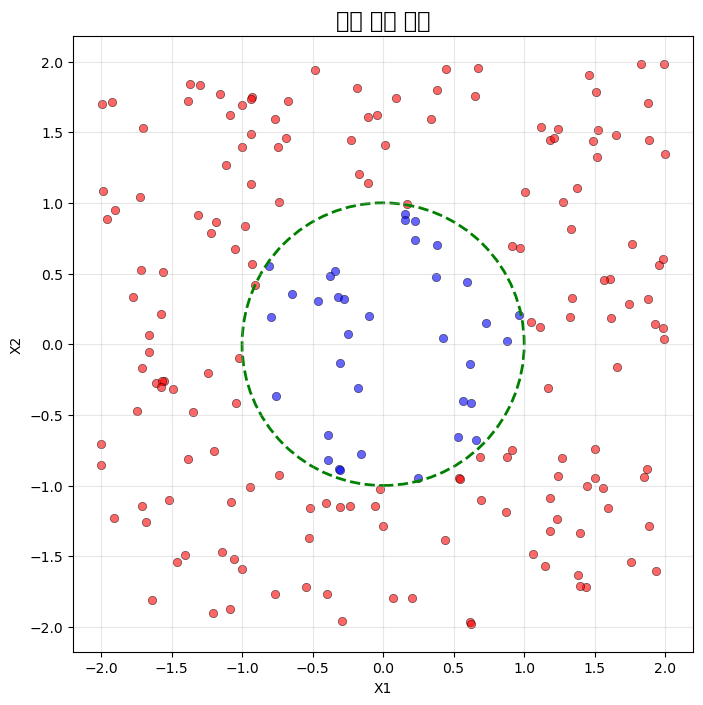

도전: 이 데이터를 분류하는 신경망을 만들어보세요!
힌트: 은닉층의 크기를 늘려보세요 (예: 2-16-16-1)


In [9]:
# 도전 과제 예시: 원형 데이터 분류
def create_circular_data(n_samples=100):
    """원형으로 분포한 2클래스 데이터 생성"""
    X = []
    y = []
    
    for _ in range(n_samples):
        # 랜덤 점 생성
        x1 = random.uniform(-2, 2)
        x2 = random.uniform(-2, 2)
        
        # 원의 안/밖으로 분류
        distance = math.sqrt(x1**2 + x2**2)
        label = 1 if distance < 1.0 else 0
        
        X.append([x1, x2])
        y.append(label)
    
    return X, y

# 데이터 생성 및 시각화
X_circle, y_circle = create_circular_data(200)

plt.figure(figsize=(8, 8))
for x, label in zip(X_circle, y_circle):
    color = 'blue' if label == 1 else 'red'
    plt.scatter(x[0], x[1], c=color, alpha=0.6, edgecolor='black', linewidth=0.5)

circle = plt.Circle((0, 0), 1, fill=False, color='green', linewidth=2, linestyle='--')
plt.gca().add_patch(circle)

plt.title('원형 분류 문제', fontsize=16)
plt.xlabel('X1')
plt.ylabel('X2')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

print("도전: 이 데이터를 분류하는 신경망을 만들어보세요!")
print("힌트: 은닉층의 크기를 늘려보세요 (예: 2-16-16-1)")

## 🎉 축하합니다!

신경망의 기초를 완성했습니다! 🎊

### 다음 단계:
- **Day 2**: 벡터/행렬 연산으로 확장
- **Day 3**: Attention 메커니즘
- **Day 4**: Transformer 구현
- **Day 5**: 실제 텍스트 생성

**"The best way to understand neural networks is to implement them from scratch!"**
- Andrej Karpathy